In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import time
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seed untuk reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Device: {torch.cuda.get_device_name(0)}")


c:\Users\Asus\.conda\envs\DeepLearning\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch Version: 2.9.1+cu130
CUDA Available: True
CUDA Device: NVIDIA GeForce RTX 4050 Laptop GPU


## Konfigurasi Path dan Hyperparameter

In [2]:
DATASET_PATH = './dataset'
TRAIN_PATH = os.path.join(DATASET_PATH, 'train')
TEST_PATH = os.path.join(DATASET_PATH, 'test')

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10
LR = 1e-4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_WORKERS = os.cpu_count() if os.name != 'nt' else 0

os.makedirs('./models', exist_ok=True)
os.makedirs('./results', exist_ok=True)

## Data Preprocessing dan Augmentasi

In [3]:
# Data transforms untuk training (dengan augmentasi)
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Data transforms untuk validation/testing (tanpa augmentasi)
val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Data transforms berhasil dibuat")

Data transforms berhasil dibuat


## Load Dataset

In [4]:
class MakananDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        
        self.classes = sorted(self.data_frame['label'].unique().tolist())
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        
    def __len__(self):
        return len(self.data_frame)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data_frame.iloc[idx]['filename'])
        from PIL import Image
        image = Image.open(img_name).convert('RGB')
        label = self.class_to_idx[self.data_frame.iloc[idx]['label']]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

train_csv = os.path.join(DATASET_PATH, 'train.csv')
train_dataset = MakananDataset(csv_file=train_csv, img_dir=TRAIN_PATH, transform=train_transforms)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = torch.utils.data.random_split(
    train_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

val_dataset = MakananDataset(csv_file=train_csv, img_dir=TRAIN_PATH, transform=val_transforms)

class SubsetWithTransform(torch.utils.data.Subset):
    def __init__(self, subset, transform_dataset):
        super().__init__(transform_dataset, subset.indices)
        
    def __getitem__(self, idx):
        return self.dataset[self.indices[idx]]

val_subset = SubsetWithTransform(val_subset, val_dataset)

# DataLoader
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, 
                         shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, 
                       shuffle=False, num_workers=NUM_WORKERS)

# Informasi dataset
num_classes = len(train_dataset.classes)
class_names = train_dataset.classes

print(f"Jumlah kelas: {num_classes}")
print(f"Nama kelas: {class_names}")
print(f"Total data: {len(train_dataset)}")
print(f"Training data: {len(train_subset)}")
print(f"Validation data: {len(val_subset)}")
print(f"Jumlah batch training: {len(train_loader)}")
print(f"Jumlah batch validation: {len(val_loader)}")

Jumlah kelas: 5
Nama kelas: ['bakso', 'gado_gado', 'nasi_goreng', 'rendang', 'soto_ayam']
Total data: 1108
Training data: 886
Validation data: 222
Jumlah batch training: 28
Jumlah batch validation: 7


## Visualisasi Sample Dataset

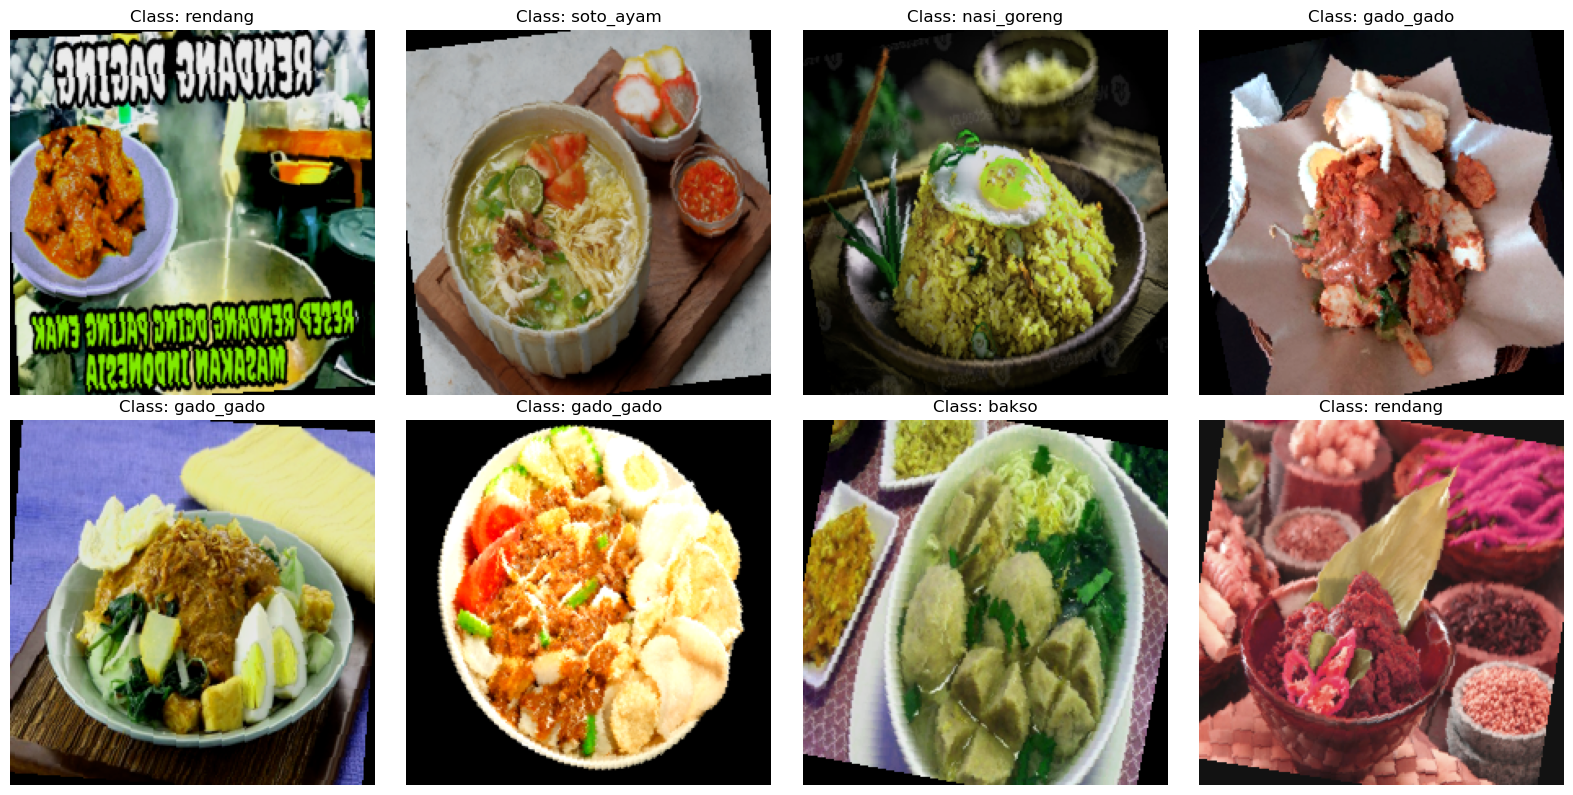

In [5]:
# Visualisasi beberapa sample dari dataset
def visualize_samples(loader, class_names, num_samples=8):
    dataiter = iter(loader)
    images, labels = next(dataiter)
    
    # Denormalize untuk visualisasi
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    images = images * std + mean
    images = torch.clamp(images, 0, 1)
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            img = images[i].permute(1, 2, 0).numpy()
            ax.imshow(img)
            ax.set_title(f"Class: {class_names[labels[i]]}")
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_samples(train_loader, class_names)

## Fungsi untuk Menghitung Parameter Model

In [6]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = total_params - trainable_params
    
    # Estimasi ukuran model dalam MB (asumsi float32 = 4 bytes)
    model_size_mb = (total_params * 4) / (1024 ** 2)
    
    return {
        'total_params': total_params,
        'trainable_params': trainable_params,
        'non_trainable_params': non_trainable_params,
        'model_size_mb': model_size_mb
    }

def print_model_info(model, model_name):
    info = count_parameters(model)
    print(f"\n{'='*60}")
    print(f"Model: {model_name}")
    print(f"{'='*60}")
    print(f"Total Parameters: {info['total_params']:,}")
    print(f"Trainable Parameters: {info['trainable_params']:,}")
    print(f"Non-trainable Parameters: {info['non_trainable_params']:,}")
    print(f"Model Size: {info['model_size_mb']:.2f} MB")
    print(f"{'='*60}\n")
    
    return info


## Load Pre-trained Swin Transformer Model

In [7]:
# Load Swin Transformer model dengan pre-trained weights
# Swin-Tiny: swin_tiny_patch4_window7_224
# Swin-Small: swin_small_patch4_window7_224
# Swin-Base: swin_base_patch4_window7_224

model_swin = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=num_classes)
model_swin = model_swin.to(DEVICE)

# Print informasi model
swin_info = print_model_info(model_swin, "Swin-Tiny")



Model: Swin-Tiny
Total Parameters: 27,523,199
Trainable Parameters: 27,523,199
Non-trainable Parameters: 0
Model Size: 104.99 MB



## Load Pre-trained DeiT Model

In [8]:
# Load DeiT model dengan pre-trained weights
# DeiT-Tiny: deit_tiny_patch16_224
# DeiT-Small: deit_small_patch16_224
# DeiT-Base: deit_base_patch16_224

model_deit = timm.create_model('deit_small_patch16_224', pretrained=True, num_classes=num_classes)
model_deit = model_deit.to(DEVICE)

# Print informasi model
deit_info = print_model_info(model_deit, "DeiT-Small")


Model: DeiT-Small
Total Parameters: 21,667,589
Trainable Parameters: 21,667,589
Non-trainable Parameters: 0
Model Size: 82.66 MB



## Fungsi Training

In [9]:
def train_step(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # Update progress bar
        pbar.set_postfix({
            'loss': running_loss / (pbar.n + 1),
            'acc': 100. * correct / total
        })
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc


## Fungsi Validation

In [10]:
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        pbar = tqdm(loader, desc='Validation')
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # Collect predictions
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Update progress bar
            pbar.set_postfix({
                'loss': running_loss / (pbar.n + 1),
                'acc': 100. * correct / total
            })
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc, all_preds, all_labels

## Fungsi Training Loop Lengkap

In [11]:
def train_model(model, train_loader, val_loader, model_name, num_epochs, lr, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    best_val_acc = 0.0
    
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"{'='*60}\n")
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 40)
        
        # Training
        train_loss, train_acc = train_step(model, train_loader, criterion, optimizer, device)
        
        # Validation
        val_loss, val_acc, _, _ = validate(model, val_loader, criterion, device)
        
        # Update scheduler
        scheduler.step()
        
        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Print epoch results
        print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
        
        # Save best model
        if val_acc > best_val_acc:
            diff = val_acc - best_val_acc
            best_val_acc = val_acc
            
            os.makedirs('./models', exist_ok=True)
            save_path = f"./models/{model_name}_best.pth"
            
            torch.save(model.state_dict(), save_path)
            print(f"--> New record! (+{diff:.2f}%) Model saved to {save_path}")
            print(f"    Current Best Acc: {best_val_acc:.2f}%")
    
    print(f"Training {model_name} selesai!")
    print(f"Best Validation Accuracy: {best_val_acc:.2f}%\n")
    
    return history, best_val_acc

## Training DeiT Model

In [12]:
deit_history, deit_best_acc = train_model(
    model=model_deit,
    train_loader=train_loader,
    val_loader=val_loader,
    model_name='DeiT',
    num_epochs=EPOCHS,
    lr=LR,
    device=DEVICE
)


Training DeiT

Epoch 1/10
----------------------------------------


Validation: 100%|██████████| 7/7 [00:10<00:00,  1.48s/it, loss=0.169, acc=95]  




Train Loss: 0.6357 | Train Acc: 79.12%
Val Loss: 0.1693 | Val Acc: 95.05%
--> New record! (+95.05%) Model saved to ./models/DeiT_best.pth
    Current Best Acc: 95.05%
Epoch 2/10
----------------------------------------


Validation: 100%|██████████| 7/7 [00:07<00:00,  1.02s/it, loss=0.132, acc=95.9]




Train Loss: 0.1354 | Train Acc: 95.49%
Val Loss: 0.1325 | Val Acc: 95.95%
--> New record! (+0.90%) Model saved to ./models/DeiT_best.pth
    Current Best Acc: 95.95%
Epoch 3/10
----------------------------------------


Validation: 100%|██████████| 7/7 [00:07<00:00,  1.05s/it, loss=0.107, acc=95.5]



Train Loss: 0.0441 | Train Acc: 98.98%
Val Loss: 0.1075 | Val Acc: 95.50%
Epoch 4/10
----------------------------------------


Validation: 100%|██████████| 7/7 [00:07<00:00,  1.08s/it, loss=0.159, acc=94.6]



Train Loss: 0.0608 | Train Acc: 98.42%
Val Loss: 0.1587 | Val Acc: 94.59%
Epoch 5/10
----------------------------------------


Validation: 100%|██████████| 7/7 [00:07<00:00,  1.09s/it, loss=0.116, acc=96.8]




Train Loss: 0.0325 | Train Acc: 99.10%
Val Loss: 0.1161 | Val Acc: 96.85%
--> New record! (+0.90%) Model saved to ./models/DeiT_best.pth
    Current Best Acc: 96.85%
Epoch 6/10
----------------------------------------


Validation: 100%|██████████| 7/7 [00:09<00:00,  1.35s/it, loss=0.106, acc=95.5]



Train Loss: 0.0178 | Train Acc: 99.55%
Val Loss: 0.1062 | Val Acc: 95.50%
Epoch 7/10
----------------------------------------


Validation: 100%|██████████| 7/7 [00:09<00:00,  1.34s/it, loss=0.128, acc=95]  



Train Loss: 0.0082 | Train Acc: 99.89%
Val Loss: 0.1280 | Val Acc: 95.05%
Epoch 8/10
----------------------------------------


Validation: 100%|██████████| 7/7 [00:09<00:00,  1.35s/it, loss=0.114, acc=95.9]



Train Loss: 0.0041 | Train Acc: 100.00%
Val Loss: 0.1139 | Val Acc: 95.95%
Epoch 9/10
----------------------------------------


Validation: 100%|██████████| 7/7 [00:09<00:00,  1.37s/it, loss=0.108, acc=95.9]



Train Loss: 0.0032 | Train Acc: 100.00%
Val Loss: 0.1081 | Val Acc: 95.95%
Epoch 10/10
----------------------------------------


Validation: 100%|██████████| 7/7 [00:09<00:00,  1.40s/it, loss=0.108, acc=95.9]


Train Loss: 0.0069 | Train Acc: 99.77%
Val Loss: 0.1080 | Val Acc: 95.95%
Training DeiT selesai!
Best Validation Accuracy: 96.85%



## Training Swin Transformer Model

In [13]:
swin_history, swin_best_acc = train_model(
    model=model_swin,
    train_loader=train_loader,
    val_loader=val_loader,
    model_name='Swin',
    num_epochs=EPOCHS,
    lr=LR,
    device=DEVICE
)


Training Swin

Epoch 1/10
----------------------------------------


Validation: 100%|██████████| 7/7 [00:10<00:00,  1.45s/it, loss=0.119, acc=96.4]




Train Loss: 0.6772 | Train Acc: 77.20%
Val Loss: 0.1194 | Val Acc: 96.40%
--> New record! (+96.40%) Model saved to ./models/Swin_best.pth
    Current Best Acc: 96.40%
Epoch 2/10
----------------------------------------


Validation: 100%|██████████| 7/7 [00:10<00:00,  1.46s/it, loss=0.138, acc=95]  



Train Loss: 0.1076 | Train Acc: 96.50%
Val Loss: 0.1377 | Val Acc: 95.05%
Epoch 3/10
----------------------------------------


Validation: 100%|██████████| 7/7 [00:10<00:00,  1.47s/it, loss=0.0937, acc=96.8]




Train Loss: 0.0720 | Train Acc: 97.52%
Val Loss: 0.0937 | Val Acc: 96.85%
--> New record! (+0.45%) Model saved to ./models/Swin_best.pth
    Current Best Acc: 96.85%
Epoch 4/10
----------------------------------------


Validation: 100%|██████████| 7/7 [00:10<00:00,  1.46s/it, loss=0.134, acc=95.9]



Train Loss: 0.0495 | Train Acc: 97.97%
Val Loss: 0.1338 | Val Acc: 95.95%
Epoch 5/10
----------------------------------------


Validation: 100%|██████████| 7/7 [00:10<00:00,  1.47s/it, loss=0.211, acc=94.6]



Train Loss: 0.0414 | Train Acc: 98.53%
Val Loss: 0.2111 | Val Acc: 94.59%
Epoch 6/10
----------------------------------------


Validation: 100%|██████████| 7/7 [00:10<00:00,  1.47s/it, loss=0.111, acc=96.8]



Train Loss: 0.0222 | Train Acc: 99.77%
Val Loss: 0.1107 | Val Acc: 96.85%
Epoch 7/10
----------------------------------------


Validation: 100%|██████████| 7/7 [00:10<00:00,  1.46s/it, loss=0.076, acc=98.2] 




Train Loss: 0.0080 | Train Acc: 100.00%
Val Loss: 0.0760 | Val Acc: 98.20%
--> New record! (+1.35%) Model saved to ./models/Swin_best.pth
    Current Best Acc: 98.20%
Epoch 8/10
----------------------------------------


Validation: 100%|██████████| 7/7 [00:10<00:00,  1.44s/it, loss=0.0859, acc=97.7]



Train Loss: 0.0060 | Train Acc: 99.89%
Val Loss: 0.0859 | Val Acc: 97.75%
Epoch 9/10
----------------------------------------


Validation: 100%|██████████| 7/7 [00:10<00:00,  1.47s/it, loss=0.0826, acc=97.7]



Train Loss: 0.0060 | Train Acc: 99.89%
Val Loss: 0.0826 | Val Acc: 97.75%
Epoch 10/10
----------------------------------------


Validation: 100%|██████████| 7/7 [00:10<00:00,  1.47s/it, loss=0.0839, acc=97.7]


Train Loss: 0.0044 | Train Acc: 100.00%
Val Loss: 0.0839 | Val Acc: 97.75%
Training Swin selesai!
Best Validation Accuracy: 98.20%



## Visualisasi Learning Curves

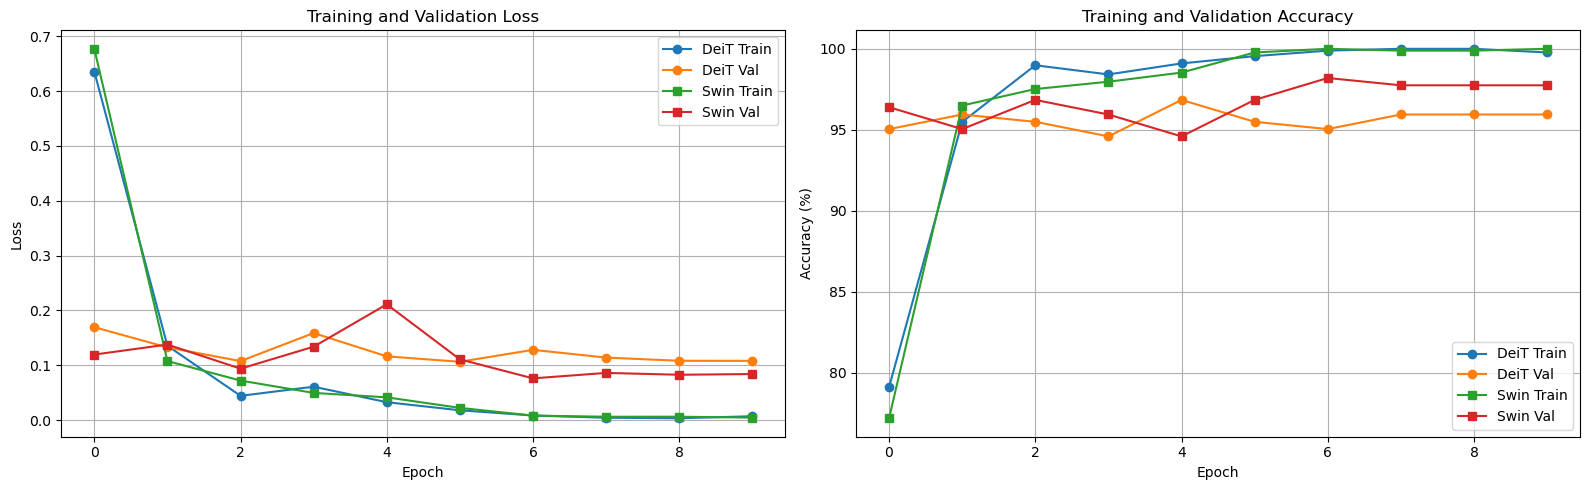

In [14]:
def plot_learning_curves(deit_history, swin_history):
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Plot Loss
    axes[0].plot(deit_history['train_loss'], label='DeiT Train', marker='o')
    axes[0].plot(deit_history['val_loss'], label='DeiT Val', marker='o')
    axes[0].plot(swin_history['train_loss'], label='Swin Train', marker='s')
    axes[0].plot(swin_history['val_loss'], label='Swin Val', marker='s')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    # Plot Accuracy
    axes[1].plot(deit_history['train_acc'], label='DeiT Train', marker='o')
    axes[1].plot(deit_history['val_acc'], label='DeiT Val', marker='o')
    axes[1].plot(swin_history['train_acc'], label='Swin Train', marker='s')
    axes[1].plot(swin_history['val_acc'], label='Swin Val', marker='s')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

plot_learning_curves(deit_history, swin_history)


## Load Best Models untuk Evaluasi

In [15]:
deit_path = './models/DeiT_best.pth'
swin_path = './models/Swin_best.pth'

# Load DeiT
if os.path.exists(deit_path):
    model_deit.load_state_dict(torch.load(deit_path, map_location=DEVICE))
    print(f"--> DeiT weights loaded from {deit_path}")
else:
    print(f"!! Warning: DeiT weights not found at {deit_path}")

# Load Swin
if os.path.exists(swin_path):
    model_swin.load_state_dict(torch.load(swin_path, map_location=DEVICE))
    print(f"--> Swin weights loaded from {swin_path}")
else:
    print(f"!! Warning: Swin weights not found at {swin_path}")

--> DeiT weights loaded from ./models/DeiT_best.pth
--> Swin weights loaded from ./models/Swin_best.pth


## Fungsi Evaluasi Lengkap

In [16]:
def evaluate_model(model, loader, device, class_names):
    model.eval()
    
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Evaluating'):
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    # Per-class metrics
    precision_per_class = precision_score(all_labels, all_preds, average=None)
    recall_per_class = recall_score(all_labels, all_preds, average=None)
    f1_per_class = f1_score(all_labels, all_preds, average=None)
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Classification report
    report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
    
    results = {
        'accuracy': accuracy * 100,
        'precision': precision * 100,
        'recall': recall * 100,
        'f1_score': f1 * 100,
        'precision_per_class': precision_per_class * 100,
        'recall_per_class': recall_per_class * 100,
        'f1_per_class': f1_per_class * 100,
        'confusion_matrix': cm,
        'classification_report': report,
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs
    }
    
    return results


##  Evaluasi DeiT Model

In [17]:
print("Evaluating DeiT Model...")
deit_results = evaluate_model(model_deit, val_loader, DEVICE, class_names)

print("\nDeiT Model - Classification Report:")
print("="*60)
print(deit_results['classification_report'])


Evaluating DeiT Model...


Evaluating: 100%|██████████| 7/7 [00:10<00:00,  1.45s/it]


DeiT Model - Classification Report:
              precision    recall  f1-score   support

       bakso     1.0000    0.9333    0.9655        45
   gado_gado     0.9778    0.9565    0.9670        46
 nasi_goreng     0.9318    1.0000    0.9647        41
     rendang     1.0000    0.9487    0.9737        39
   soto_ayam     0.9444    1.0000    0.9714        51

    accuracy                         0.9685       222
   macro avg     0.9708    0.9677    0.9685       222
weighted avg     0.9700    0.9685    0.9685       222



## Evaluasi Swin Transformer Model

In [18]:
print("Evaluating Swin Transformer Model...")
swin_results = evaluate_model(model_swin, val_loader, DEVICE, class_names)

print("\nSwin Transformer Model - Classification Report:")
print("="*60)
print(swin_results['classification_report'])


Evaluating Swin Transformer Model...


Evaluating: 100%|██████████| 7/7 [00:10<00:00,  1.43s/it]


Swin Transformer Model - Classification Report:
              precision    recall  f1-score   support

       bakso     1.0000    0.9778    0.9888        45
   gado_gado     0.9787    1.0000    0.9892        46
 nasi_goreng     1.0000    0.9512    0.9750        41
     rendang     0.9500    0.9744    0.9620        39
   soto_ayam     0.9808    1.0000    0.9903        51

    accuracy                         0.9820       222
   macro avg     0.9819    0.9807    0.9811       222
weighted avg     0.9824    0.9820    0.9820       222



## Visualisasi Confusion Matrix

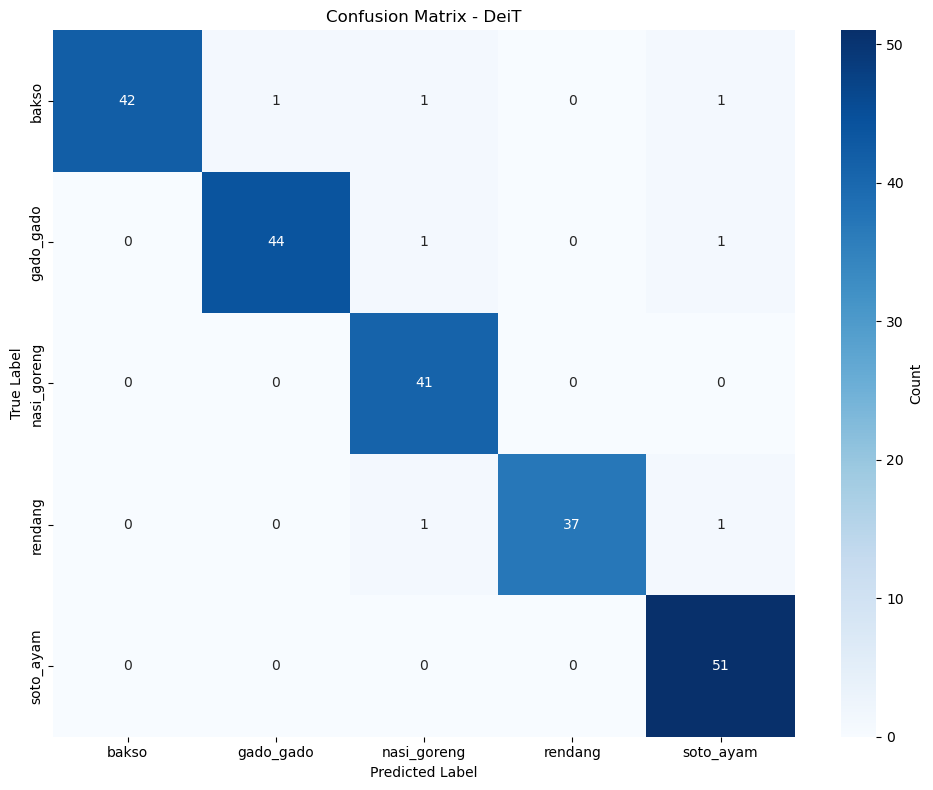

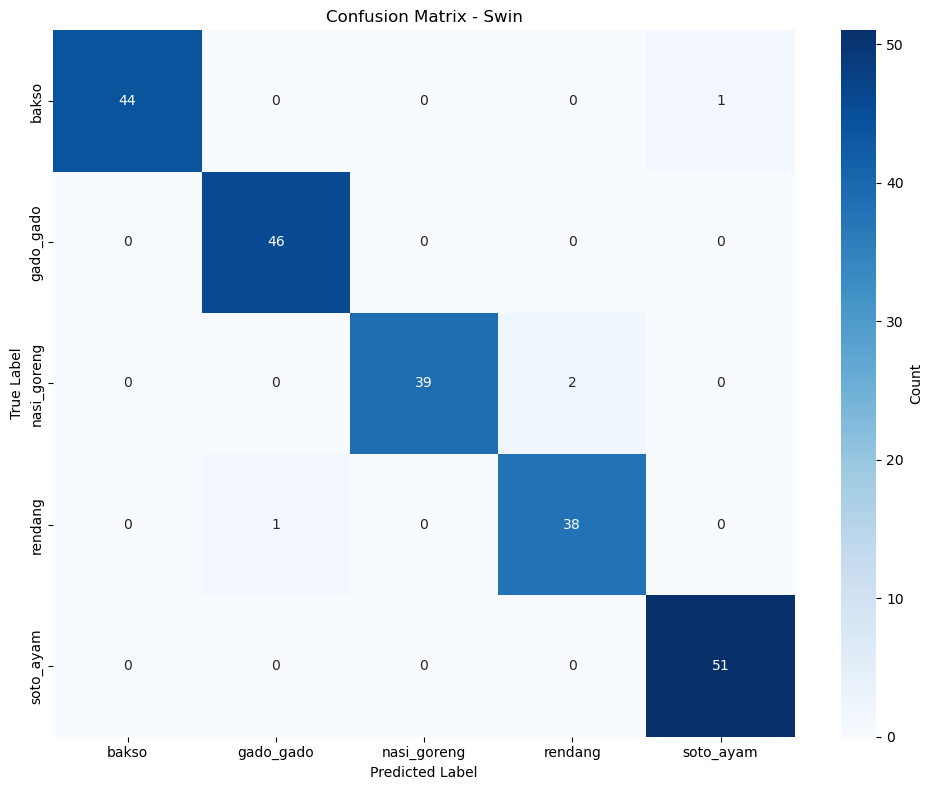

In [19]:
def plot_confusion_matrix(cm, class_names, model_name):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.tight_layout()
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(deit_results['confusion_matrix'], class_names, 'DeiT')
plot_confusion_matrix(swin_results['confusion_matrix'], class_names, 'Swin')


## Fungsi Pengukuran Inference Time

In [20]:
def measure_inference_time(model, loader, device, num_warmup=10, num_iterations=100):
    model.eval()
    
    # Warmup
    print("Warming up...")
    with torch.no_grad():
        for i, (images, _) in enumerate(loader):
            if i >= num_warmup:
                break
            images = images.to(device)
            _ = model(images)
    
    # Actual measurement
    print(f"Measuring inference time for {num_iterations} iterations...")
    times = []
    
    with torch.no_grad():
        for i, (images, _) in enumerate(tqdm(loader)):
            if i >= num_iterations:
                break
            
            images = images.to(device)
            
            # Synchronize CUDA if using GPU
            if device == 'cuda':
                torch.cuda.synchronize()
            
            start_time = time.time()
            _ = model(images)
            
            # Synchronize CUDA if using GPU
            if device == 'cuda':
                torch.cuda.synchronize()
            
            end_time = time.time()
            
            batch_time = (end_time - start_time) * 1000  # Convert to ms
            times.append(batch_time / images.size(0))  # Per image time
    
    # Calculate statistics
    avg_time = np.mean(times)
    std_time = np.std(times)
    throughput = 1000 / avg_time  # Images per second
    
    return {
        'avg_time_ms': avg_time,
        'std_time_ms': std_time,
        'throughput_fps': throughput,
        'all_times': times
    }


## Pengukuran Inference Time DeiT

In [21]:
print("Measuring DeiT Inference Time...")
deit_inference = measure_inference_time(model_deit, val_loader, DEVICE)

print("\nDeiT Inference Time:")
print(f"Average Time per Image: {deit_inference['avg_time_ms']:.2f} ± {deit_inference['std_time_ms']:.2f} ms")
print(f"Throughput: {deit_inference['throughput_fps']:.2f} images/second")


Measuring DeiT Inference Time...
Warming up...
Measuring inference time for 100 iterations...
Measuring inference time for 100 iterations...


100%|██████████| 7/7 [00:10<00:00,  1.44s/it]


DeiT Inference Time:
Average Time per Image: 3.33 ± 0.77 ms
Throughput: 300.51 images/second


## Pengukuran Inference Time Swin Transformer

In [22]:
print("Measuring Swin Transformer Inference Time...")
swin_inference = measure_inference_time(model_swin, val_loader, DEVICE)

print("\nSwin Transformer Inference Time:")
print(f"Average Time per Image: {swin_inference['avg_time_ms']:.2f} ± {swin_inference['std_time_ms']:.2f} ms")
print(f"Throughput: {swin_inference['throughput_fps']:.2f} images/second")


Measuring Swin Transformer Inference Time...
Warming up...
Measuring inference time for 100 iterations...
Measuring inference time for 100 iterations...


100%|██████████| 7/7 [00:10<00:00,  1.49s/it]


Swin Transformer Inference Time:
Average Time per Image: 5.10 ± 1.50 ms
Throughput: 196.15 images/second


## Tabel Perbandingan Parameter

In [23]:
res = {
    'Model': ['DeiT', 'Swin'],
    'Params': [deit_info['total_params'], swin_info['total_params']],
    'Size_MB': [deit_info['model_size_mb'], swin_info['model_size_mb']]
}
df = pd.DataFrame(res)

print(df)

# Cek bedanya berapa persen
diff_mb = swin_info['model_size_mb'] - deit_info['model_size_mb']
print(f"\nNote: Swin is heavier by {diff_mb:.2f} MB")

# Save
df.to_csv('./results/params.csv', index=False)

  Model    Params     Size_MB
0  DeiT  21667589   82.655293
1  Swin  27523199  104.992672

Note: Swin is heavier by 22.34 MB


## Tabel Perbandingan Performa

In [24]:
res_data = {
    'Model': ['DeiT', 'Swin'],
    'Acc': [deit_results['accuracy'], swin_results['accuracy']],
    'Prec': [deit_results['precision'], swin_results['precision']],
    'Recall': [deit_results['recall'], swin_results['recall']],
    'F1': [deit_results['f1_score'], swin_results['f1_score']],
    'Best_Val': [deit_best_acc, swin_best_acc]
}

df_perf = pd.DataFrame(res_data)

print("\n--- Final Results ---")
print(df_perf.round(2))

# Quick check: Siapa yang menang?
winner = "Swin" if swin_best_acc > deit_best_acc else "DeiT"
diff = abs(swin_best_acc - deit_best_acc)
print(f"\n>> Conclusion: {winner} is better by {diff:.2f}%")

# Save
df_perf.to_csv('./results/performance_comparison.csv', index=False)


--- Final Results ---
  Model    Acc   Prec  Recall     F1  Best_Val
0  DeiT  96.85  97.00   96.85  96.85     96.85
1  Swin  98.20  98.24   98.20  98.20     98.20

>> Conclusion: Swin is better by 1.35%


## Tabel Perbandingan Inference Time

In [25]:
inf_data = {
    'Model': ['DeiT', 'Swin'],
    'Latency (ms)': [deit_inference['avg_time_ms'], swin_inference['avg_time_ms']],
    'FPS': [deit_inference['throughput_fps'], swin_inference['throughput_fps']]
}

df_inf = pd.DataFrame(inf_data)

print("\n--- Speed Comparison ---")
print(df_inf.round(2))

fps_deit = deit_inference['throughput_fps']
fps_swin = swin_inference['throughput_fps']

if fps_deit > fps_swin:
    ratio = fps_deit / fps_swin
    print(f"\n>> Result: DeiT is {ratio:.1f}x faster than Swin")
else:
    ratio = fps_swin / fps_deit
    print(f"\n>> Result: Swin is {ratio:.1f}x faster than DeiT")

# Save
df_inf.to_csv('./results/inference_comparison.csv', index=False)


--- Speed Comparison ---
  Model  Latency (ms)     FPS
0  DeiT          3.33  300.51
1  Swin          5.10  196.15

>> Result: DeiT is 1.5x faster than Swin


## Tabel Perbandingan Per-Class Metrics

In [26]:
per_class_comparison = []

for i, class_name in enumerate(class_names):
    per_class_comparison.append({
        'Class': class_name,
        'DeiT Precision (%)': deit_results['precision_per_class'][i],
        'Swin Precision (%)': swin_results['precision_per_class'][i],
        'DeiT Recall (%)': deit_results['recall_per_class'][i],
        'Swin Recall (%)': swin_results['recall_per_class'][i],
        'DeiT F1-Score (%)': deit_results['f1_per_class'][i],
        'Swin F1-Score (%)': swin_results['f1_per_class'][i]
    })

per_class_df = pd.DataFrame(per_class_comparison)

print("\n" + "="*100)
print("PERBANDINGAN METRIK PER KELAS")
print("="*100)
print(per_class_df.to_string(index=False))
print("="*100 + "\n")

# Save
per_class_df.to_csv('./results/per_class_comparison.csv', index=False)



PERBANDINGAN METRIK PER KELAS
      Class  DeiT Precision (%)  Swin Precision (%)  DeiT Recall (%)  Swin Recall (%)  DeiT F1-Score (%)  Swin F1-Score (%)
      bakso          100.000000          100.000000        93.333333        97.777778          96.551724          98.876404
  gado_gado           97.777778           97.872340        95.652174       100.000000          96.703297          98.924731
nasi_goreng           93.181818          100.000000       100.000000        95.121951          96.470588          97.500000
    rendang          100.000000           95.000000        94.871795        97.435897          97.368421          96.202532
  soto_ayam           94.444444           98.076923       100.000000       100.000000          97.142857          99.029126



## Visualisasi Perbandingan Bar Chart

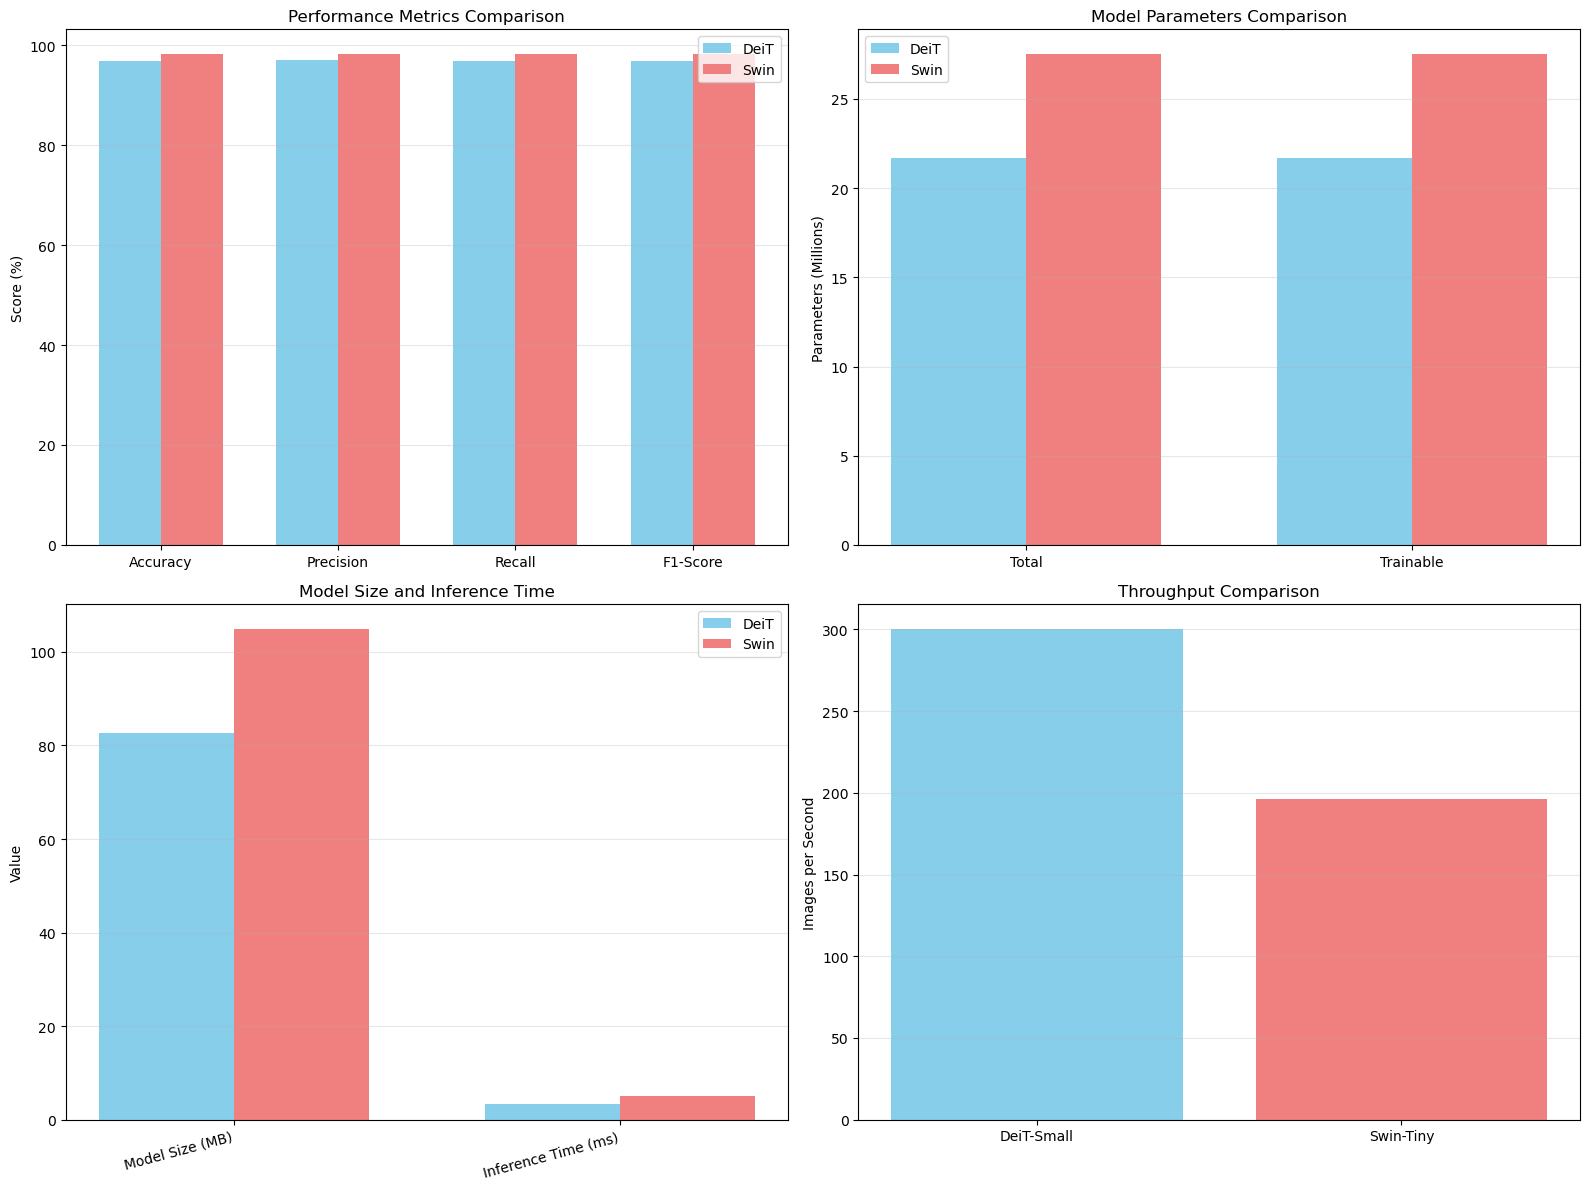

In [27]:
def plot_comparison_charts():
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    models = ['DeiT-Small', 'Swin-Tiny']
    
    # 1. Performance Metrics
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    deit_scores = [deit_results['accuracy'], deit_results['precision'], 
                   deit_results['recall'], deit_results['f1_score']]
    swin_scores = [swin_results['accuracy'], swin_results['precision'], 
                   swin_results['recall'], swin_results['f1_score']]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    axes[0, 0].bar(x - width/2, deit_scores, width, label='DeiT', color='skyblue')
    axes[0, 0].bar(x + width/2, swin_scores, width, label='Swin', color='lightcoral')
    axes[0, 0].set_ylabel('Score (%)')
    axes[0, 0].set_title('Performance Metrics Comparison')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels(metrics)
    axes[0, 0].legend()
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # 2. Parameters
    param_types = ['Total', 'Trainable']
    deit_params = [deit_info['total_params']/1e6, deit_info['trainable_params']/1e6]
    swin_params = [swin_info['total_params']/1e6, swin_info['trainable_params']/1e6]
    
    x = np.arange(len(param_types))
    axes[0, 1].bar(x - width/2, deit_params, width, label='DeiT', color='skyblue')
    axes[0, 1].bar(x + width/2, swin_params, width, label='Swin', color='lightcoral')
    axes[0, 1].set_ylabel('Parameters (Millions)')
    axes[0, 1].set_title('Model Parameters Comparison')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(param_types)
    axes[0, 1].legend()
    axes[0, 1].grid(axis='y', alpha=0.3)
    
    # 3. Model Size and Inference Time
    size_time = ['Model Size (MB)', 'Inference Time (ms)']
    deit_size_time = [deit_info['model_size_mb'], deit_inference['avg_time_ms']]
    swin_size_time = [swin_info['model_size_mb'], swin_inference['avg_time_ms']]
    
    x = np.arange(len(size_time))
    axes[1, 0].bar(x - width/2, deit_size_time, width, label='DeiT', color='skyblue')
    axes[1, 0].bar(x + width/2, swin_size_time, width, label='Swin', color='lightcoral')
    axes[1, 0].set_ylabel('Value')
    axes[1, 0].set_title('Model Size and Inference Time')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(size_time, rotation=15, ha='right')
    axes[1, 0].legend()
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # 4. Throughput
    throughput_data = [deit_inference['throughput_fps'], swin_inference['throughput_fps']]
    axes[1, 1].bar(models, throughput_data, color=['skyblue', 'lightcoral'])
    axes[1, 1].set_ylabel('Images per Second')
    axes[1, 1].set_title('Throughput Comparison')
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_comparison_charts()
